In [45]:
# data
import nfl_data_py as nfl

# data loading and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# models
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance

# interpretation
import shap
from interpret import show

# pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.feature_selection import RFECV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, nan_euclidean_distances

pd.set_option('display.max_columns', None)  # None zeigt alle Spalten
pd.set_option('display.max_rows', None)  # Alle Zeilen anzeigen, vorsichtig bei großen DataFrames
pd.set_option('display.width', 1000)  # Breite anpassen


In [46]:
df_ids = nfl.import_ids()
df_weekly = nfl.import_weekly_data(list(range(2018, 2025)))
df_draft = nfl.import_draft_picks(list(range(1994, 2024)))
df_schedule = nfl.import_schedules(list(range(2018, 2025)))
df_rec_pfr = nfl.import_weekly_pfr('rec', list(range(2018, 2025)))

df_weekly = df_weekly[(df_weekly['season_type'] == 'REG') & (df_weekly['position'].isin(['WR', 'TE']))]

df_weekly['game_id_home_away'] = df_weekly['season'].astype(str) + '_' + df_weekly['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly['recent_team']+'_'+df_weekly['opponent_team']
df_weekly['game_id_away_home'] = df_weekly['season'].astype(str) + '_' + df_weekly['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly['opponent_team']+'_'+df_weekly['recent_team']

df_draft = df_draft.rename(columns={'gsis_id': 'player_id', 'season': 'draft_season'})
df_ids = df_ids.rename(columns={'gsis_id': 'player_id', 'pfr_id': 'pfr_player_id'})

df_merged = pd.melt(
    df_weekly,
    id_vars=['player_id', 'position', 'season', 'week', 'recent_team', 'opponent_team', 'interceptions', 'sack_fumbles_lost', 'rushing_fumbles_lost', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_2pt_conversions', 'receiving_fumbles_lost', 'racr', 'wopr', 'fantasy_points'],
    value_vars=['game_id_home_away', 'game_id_away_home'],
    var_name='game_id_type',
    value_name='game_id'
)

df_merged = pd.merge(df_merged, df_ids[['player_id', 'pfr_player_id']], on = 'player_id', how = 'left')
df_merged = pd.merge(df_merged, df_draft[['player_id', 'pick', 'draft_season']], on = 'player_id', how = 'inner')
df_merged = pd.merge(df_merged, df_schedule[['game_id', 'home_team']], on='game_id', how='inner')
df_merged = pd.merge(df_merged, df_rec_pfr[['pfr_player_id', 'season', 'week', 'receiving_rat']], on = ['pfr_player_id', 'season', 'week'], how = 'left')

df_merged = df_merged.drop(columns=['game_id', 'game_id_type', 'pfr_player_id'])

df_merged.info()

Downcasting floats.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16540 entries, 0 to 16539
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player_id                  16540 non-null  object 
 1   position                   16540 non-null  object 
 2   season                     16540 non-null  int32  
 3   week                       16540 non-null  int32  
 4   recent_team                16540 non-null  object 
 5   opponent_team              16540 non-null  object 
 6   interceptions              16540 non-null  float32
 7   sack_fumbles_lost          16540 non-null  int32  
 8   rushing_fumbles_lost       16540 non-null  float32
 9   receptions                 16540 non-null  int32  
 10  targets                    16540 non-null  int32  
 11  receiving_yards            16540 non-null  float32
 12  receiving_tds              16540 non-null  int32  
 13  receiving_2pt_conversions 

In [47]:
df_merged['rookie_flag'] = (df_merged['season'] == df_merged['draft_season']).astype(int)

df_merged['last_season_data_flag'] = (df_merged['week'] < 6).astype(int)

df_merged['turnover'] = (
    df_merged['interceptions'] +
    df_merged['sack_fumbles_lost'] +
    df_merged['rushing_fumbles_lost'] +
    df_merged['receiving_fumbles_lost']
)

df_merged['receiving_pts'] = (df_merged['receiving_tds'] * 6) + (df_merged['receiving_2pt_conversions'] * 2)

df_merged = df_merged.drop(columns=['draft_season', 'interceptions', 'sack_fumbles_lost', 'rushing_fumbles_lost', 'receiving_fumbles_lost', 
                                    'receiving_tds', 'receiving_2pt_conversions'])

# Liste der Spalten, für die Rolling-Features erstellt werden sollen
columns_to_roll = ['receptions', 'targets', 'receiving_yards', 'fantasy_points', 'turnover', 'receiving_pts', 'racr', 'wopr', 'receiving_rat']


# Funktion zum Erstellen von Rolling-Features
def create_rolling_features(df):
    # Sortiere nach player_id und GJAHRPERIODKey
    df = df.sort_values(by=['player_id', 'season', 'week']).reset_index(drop=True)

    df['cnt_games_over_20pts_l5w'] = (
        df.groupby('player_id')['fantasy_points']
        .apply(lambda x: x.shift(1).rolling(window=5, min_periods=5).apply(lambda y: (y > 20).sum()))
        .reset_index(level=0, drop=True)
    )

   # Rolling-Features erstellen
    for col in columns_to_roll:

        feature_name_1 = f"ewm_{col}_l5w"
        df[feature_name_1] = (
            df.groupby('player_id')[col]
            .apply(lambda x: x.shift(1).ewm(span=5, min_periods=5).mean())
            .reset_index(level=0, drop=True)
        )

        for metric in ['mean', 'median', 'std']:
            feature_name_2 = f"{metric}_{col}_l5w"
            rolling_result_5w = (
                df.groupby('player_id')[col]
                  .apply(lambda x: x.shift(1).rolling(window=5, min_periods=5).agg(metric))  # shift(1) schließt aktuelle Woche aus
                  .reset_index(level=0, drop=True)  # Index zurücksetzen
            )
            # Einfügen der Rolling-Metrik
            df[feature_name_2] = rolling_result_5w

        for metric in ['max', 'min', 'mean']:
            feature_name_3 = f"{metric}_{col}_l3w"
            # Berechnung der Rolling-Metrik (ohne aktuelle Woche)
            rolling_result_3w = (
                df.groupby('player_id')[col]
                  .apply(lambda x: x.shift(1).rolling(window=3, min_periods=3).agg(metric))  # shift(1) schließt aktuelle Woche aus
                  .reset_index(level=0, drop=True)  # Index zurücksetzen
            )
            # Einfügen der Rolling-Metrik
            df[feature_name_3] = rolling_result_3w

    return df


# Anwendung auf df_merged
df_merged = create_rolling_features(df_merged)

df_merged = df_merged.dropna()

df_merged = df_merged.drop(columns=['receptions', 'targets', 'receiving_yards', 'turnover', 'receiving_pts', 'racr', 'wopr', 'receiving_rat'])

df_merged['player_id'] = df_merged['player_id'].str.replace('00-00', '').astype(int)

df_merged['home'] = (df_merged['home_team'] == df_merged['recent_team']).astype(int)
df_merged = df_merged.drop(columns=['home_team'])

df_merged.info()


<class 'pandas.core.frame.DataFrame'>
Index: 13560 entries, 5 to 16538
Data columns (total 75 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   player_id                   13560 non-null  int64  
 1   position                    13560 non-null  object 
 2   season                      13560 non-null  int32  
 3   week                        13560 non-null  int32  
 4   recent_team                 13560 non-null  object 
 5   opponent_team               13560 non-null  object 
 6   fantasy_points              13560 non-null  float32
 7   pick                        13560 non-null  int32  
 8   rookie_flag                 13560 non-null  int64  
 9   last_season_data_flag       13560 non-null  int64  
 10  cnt_games_over_20pts_l5w    13560 non-null  float64
 11  ewm_receptions_l5w          13560 non-null  float64
 12  mean_receptions_l5w         13560 non-null  float64
 13  median_receptions_l5w       13560 no

In [48]:
X_train = df_merged[df_merged['season'].isin([2018, 2019, 2020, 2021, 2022, 2023])].drop(columns=['fantasy_points'])
y_train = df_merged[df_merged['season'].isin([2018, 2019, 2020, 2021, 2022, 2023])]['fantasy_points']

X_val = df_merged[df_merged['season']==2023].drop(columns=['fantasy_points'])
y_val = df_merged[df_merged['season']==2023]['fantasy_points']

X_test = df_merged[df_merged['season']==2024].drop(columns=['fantasy_points'])
y_test = df_merged[df_merged['season']==2024]['fantasy_points']

In [49]:
categorical_features = ['position', 'opponent_team', 'recent_team']
numeric_features = list(set(X_train.columns) - set(categorical_features))

preprocessor = ColumnTransformer(transformers=[
    ("num", SimpleImputer(strategy="median"), numeric_features),
    ("cat", OneHotEncoder(drop = 'first', sparse_output=False), categorical_features), 
])

xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("scaler", StandardScaler()),
    ("model", XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42))
])

xgb.fit(X_train, y_train)

xgb.score(X_test, y_test)

0.2072594165802002

In [50]:
X_train = pd.get_dummies(X_train, columns=['position', 'opponent_team', 'recent_team'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['position', 'opponent_team', 'recent_team'], drop_first=True)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns= X_test.columns)


In [51]:
# define a grid of hyperparameters and possible values
xgb_grid = {
    "max_depth": [3, 6, 7, None],
    "learning_rate": [0.05, 0.1, 0.3],
    "n_estimators": [100, 500, 1000]
}

from sklearn.model_selection import GridSearchCV

gridSearch = GridSearchCV(XGBRegressor(), xgb_grid, verbose=2, cv=TimeSeriesSplit(n_splits=3))
gridSearch.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time=   0.6s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time=   0.7s
[CV] END .learning_rate=0.05, max_depth=3, n_estimators=1000; total time=   1.2s
[CV] END .learning_rate=0.05, max_depth=3, n_estimators=1000; total time=   1.2s
[CV] END .learning_rate=0.05, max_depth=3, n_estimators=1000; total time=   1.4s
[CV] END ..learning_rate=0.05, max_depth=6, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=6, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=6, n_e

KeyboardInterrupt: 

In [36]:
results = pd.DataFrame(gridSearch.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.141417,0.016046,0.010099,0.000137,0.05,3,100,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.182207,0.054265,0.202150,0.146207,0.065521,1
1,0.561541,0.063269,0.011427,0.000144,0.05,3,500,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.135898,-0.239445,0.132915,0.009789,0.176239,6
2,1.098091,0.123999,0.013145,0.000333,0.05,3,1000,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.084521,-0.440659,0.046278,-0.103287,0.239069,14
3,0.316698,0.028804,0.010920,0.000280,0.05,6,100,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.149964,-0.183611,0.152451,0.039602,0.157838,4
4,1.477480,0.083865,0.014104,0.000298,0.05,6,500,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.085957,-0.538976,-0.018020,-0.157013,0.273404,17
5,3.090375,0.413884,0.020940,0.001916,0.05,6,1000,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.067357,-0.593119,-0.079831,-0.201864,0.283109,24
6,0.482101,0.046016,0.011590,0.000352,0.05,7,100,"{'learning_rate': 0.05, 'max_depth': 7, 'n_est...",0.141877,-0.067116,0.153415,0.076059,0.101350,3
7,2.005573,0.137683,0.015421,0.000350,0.05,7,500,"{'learning_rate': 0.05, 'max_depth': 7, 'n_est...",0.105821,-0.236330,0.016405,-0.038035,0.144890,10
8,4.074686,0.417221,0.020608,0.000712,0.05,7,1000,"{'learning_rate': 0.05, 'max_depth': 7, 'n_est...",0.100952,-0.289541,-0.029298,-0.072629,0.162336,12
9,0.328654,0.028493,0.011106,0.000290,0.05,None,100,"{'learning_rate': 0.05, 'max_depth': None, 'n_...",0.149964,-0.183611,0.152451,0.039602,0.157838,4


In [37]:
# get the best model and fit it on the complete  set
bestModel = gridSearch.best_estimator_.fit(X_train, y_train)
bestModel.score(X_test, y_test)

0.2066887617111206

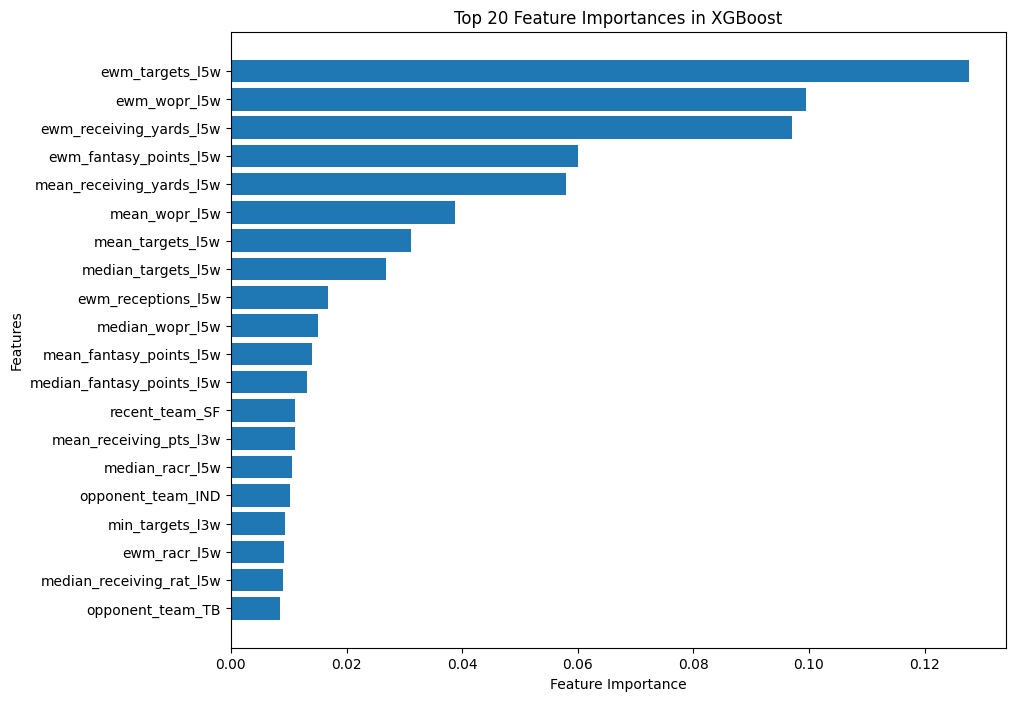

In [ ]:
# Hole die Feature-Wichtigkeiten
feature_importances = bestModel.feature_importances_

# Erstelle ein DataFrame für Features und deren Wichtigkeiten
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sortiere die Feature-Wichtigkeiten absteigend
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Wähle die Top 20 Features
top_features = feature_importance_df.head(20)

# Plotten der Feature-Wichtigkeiten
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.gca().invert_yaxis()  # Um die höchste Wichtigkeit oben anzuzeigen
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 20 Feature Importances in XGBoost")
plt.show()

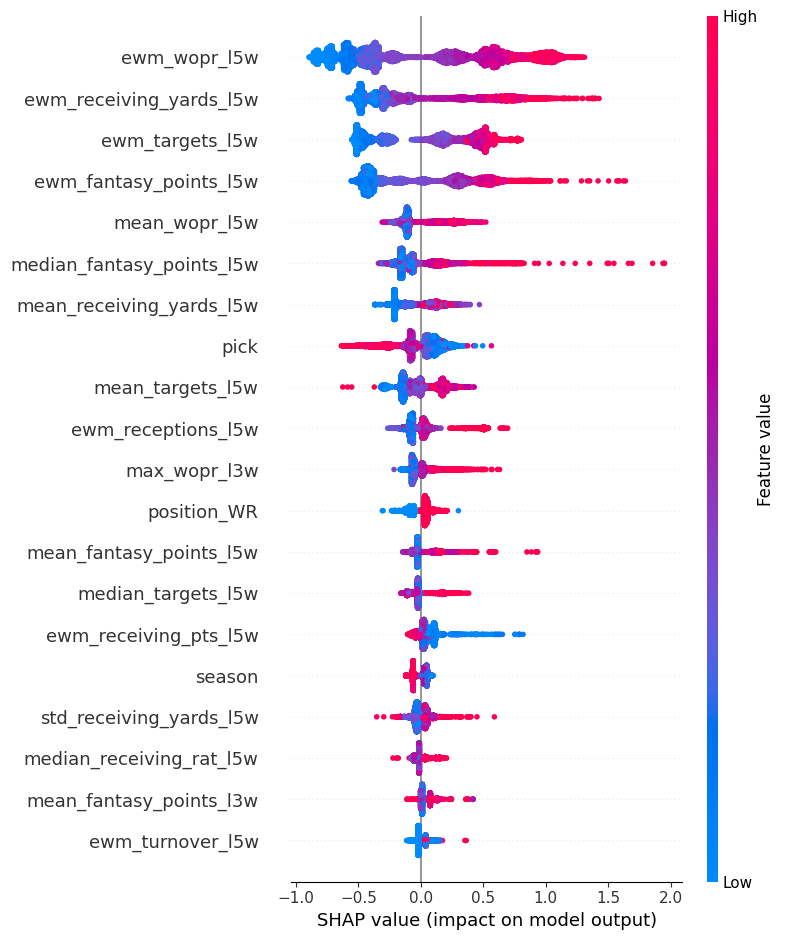

In [ ]:
import shap

# Berechne SHAP-Werte
explainer = shap.TreeExplainer(bestModel)
shap_values = explainer.shap_values(X_train)

# Plot der Feature-Wichtigkeit
shap.summary_plot(shap_values, X_train)


In [ ]:
rfe = RFECV(estimator=bestModel, step=1, cv=5, scoring="r2")
rfe.fit(X_train, y_train)

# Ausgewählte Features anzeigen
print("Ausgewählte Features:", X_train.columns[rfe.support_])

Ausgewählte Features: Index(['ewm_targets_l5w', 'ewm_receiving_yards_l5w', 'mean_receiving_yards_l5w', 'ewm_fantasy_points_l5w', 'ewm_wopr_l5w', 'mean_wopr_l5w'], dtype='object')


In [42]:
len(X_train.columns[rfe.support_])

6

In [43]:
rfe.score(X_test, y_test)

0.20785754919052124

In [44]:
print('mean absolute error: ' + str(mean_absolute_error(y_test, rfe.predict(X_test))))
print('mean squared error: ' + str(mean_squared_error(y_test, rfe.predict(X_test))))
print('root mean squared error: ' + str(root_mean_squared_error(y_test, rfe.predict(X_test))))
print('r2 score: ' + str(r2_score(y_test, rfe.predict(X_test))))


from scipy.stats import spearmanr
# Erstelle eine Rangliste basierend auf predicted und tatsächlichen Punkten und berechne die Spearman-Rangkorrelation
rank_predicted = pd.Series(rfe.predict(X_test)).rank(ascending=False)
rank_actual = pd.Series(y_test).rank(ascending=False)
spearman_corr, _ = spearmanr(rank_predicted, rank_actual)
print(f"Spearman-Rangkorrelation: {spearman_corr:.2f}")



mean absolute error: 3.7330444
mean squared error: 25.154497
root mean squared error: 5.0154257
r2 score: 0.20785754919052124
Spearman-Rangkorrelation: 0.51
